<b>Project 3 - Closest pairs and clustering algorithms</b>

For Project 3, you will also implement two methods for computing closest pairs and two methods for clustering data. In Application 3, you will then compare these two clustering methods in terms of efficiency, automation, and quality.
The Cluster class
The class initializer Cluster(FIPS_codes, horiz_center, vert_center, total_population, average_risk) takes as input a set of county codes, the horizontal/vertical position of the cluster's center as well as the total population and averaged cancer risks for the cluster. The class definition supports methods for extracting these attributes of the cluster. The Cluster class also implements two methods that we will use extensively in implementing the Project.

distance(other_cluster) - Computes the Euclidean distance between the centers of the clusters self and other_cluster.

merge_clusters(other_cluster) - Mutates the cluster self to contain the union of the counties in self and other_cluster. The method updates the center of the mutated cluster using a weighted average of the centers of the two clusters based on their respective total populations. An updated cancer risk for the merged cluster is computed in a similar manner.

Mathematically, a clustering is a set of sets of points. In Python, modeling a clustering as a set of sets is impossible since the elements of a set must be immutable. This restriction guides us to model a set of clusters as a list of Cluster objects. This choice makes implementing an "indexed" set as described in the pseudo-code easy.

In [1]:
"""
Cluster class for Module 3
"""

import math


class Cluster:
    """
    Class for creating and merging clusters of counties
    """
    
    def __init__(self, fips_codes, horiz_pos, vert_pos, population, risk):
        """
        Create a cluster based the models a set of counties' data
        """
        self._fips_codes = fips_codes
        self._horiz_center = horiz_pos
        self._vert_center = vert_pos
        self._total_population = population
        self._averaged_risk = risk
        
        
    def __repr__(self):
        """
        String representation assuming the module is "alg_cluster".
        """
        rep = "alg_cluster.Cluster("
        rep += str(self._fips_codes) + ", "
        rep += str(self._horiz_center) + ", "
        rep += str(self._vert_center) + ", "
        rep += str(self._total_population) + ", "
        rep += str(self._averaged_risk) + ")"
        return rep


    def fips_codes(self):
        """
        Get the cluster's set of FIPS codes
        """
        return self._fips_codes
    
    def horiz_center(self):
        """
        Get the averged horizontal center of cluster
        """
        return self._horiz_center
    
    def vert_center(self):
        """
        Get the averaged vertical center of the cluster
        """
        return self._vert_center
    
    def total_population(self):
        """
        Get the total population for the cluster
        """
        return self._total_population
    
    def averaged_risk(self):
        """
        Get the averaged risk for the cluster
        """
        return self._averaged_risk
   
        
    def copy(self):
        """
        Return a copy of a cluster
        """
        copy_cluster = Cluster(set(self._fips_codes), self._horiz_center, self._vert_center,
                               self._total_population, self._averaged_risk)
        return copy_cluster


    def distance(self, other_cluster):
        """
        Compute the Euclidean distance between two clusters
        """
        vert_dist = self._vert_center - other_cluster.vert_center()
        horiz_dist = self._horiz_center - other_cluster.horiz_center()
        return math.sqrt(vert_dist ** 2 + horiz_dist ** 2)
        
    def merge_clusters(self, other_cluster):
        """
        Merge one cluster into another
        The merge uses the relatively populations of each
        cluster in computing a new center and risk
        
        Note that this method mutates self
        """
        if len(other_cluster.fips_codes()) == 0:
            return self
        else:
            self._fips_codes.update(set(other_cluster.fips_codes()))
 
            # compute weights for averaging
            self_weight = float(self._total_population)                        
            other_weight = float(other_cluster.total_population())
            self._total_population = self._total_population + other_cluster.total_population()
            self_weight /= self._total_population
            other_weight /= self._total_population
                    
            # update center and risk using weights
            self._vert_center = self_weight * self._vert_center + other_weight * other_cluster.vert_center()
            self._horiz_center = self_weight * self._horiz_center + other_weight * other_cluster.horiz_center()
            self._averaged_risk = self_weight * self._averaged_risk + other_weight * other_cluster.averaged_risk()
            return self

    def cluster_error(self, data_table):
        """
        Input: data_table is the original table of cancer data used in creating the cluster.
        
        Output: The error as the sum of the square of the distance from each county
        in the cluster to the cluster center (weighted by its population)
        """
        # Build hash table to accelerate error computation
        fips_to_line = {}
        for line_idx in range(len(data_table)):
            line = data_table[line_idx]
            fips_to_line[line[0]] = line_idx
        
        # compute error as weighted squared distance from counties to cluster center
        total_error = 0
        counties = self.fips_codes()
        for county in counties:
            line = data_table[fips_to_line[county]]
            singleton_cluster = Cluster(set([line[0]]), line[1], line[2], line[3], line[4])
            singleton_distance = self.distance(singleton_cluster)
            total_error += (singleton_distance ** 2) * singleton_cluster.total_population()
        return total_error
            

<b>Closest pair functions</b>
<p>For this part of the Project, your task is to implement the two algorithms for computing closest pairs discussed in Homework 3. For the fast method, you will also implement its helper function separately to make debugging/testing your code easier. Your implementations should work on lists of Cluster objects and compute distances between clusters using the distance method.</p> 
<p>As one important coding note, you will need to sort a list of clusters by the horizontal (as well as vertical) positions of the cluster centers. This operation can be done in a single line of Python using the sort method for lists by providing a key argument of the form:</p>

cluster_list.sort(key = lambda cluster: cluster.horiz_center())

In [2]:
#import math
#import alg_cluster

def pair_distance(cluster_list, idx1, idx2):
    """
    Helper function that computes Euclidean distance between two clusters in a list

    Input: cluster_list is list of clusters, idx1 and idx2 are integer indices for two clusters
    
    Output: tuple (dist, idx1, idx2) where dist is distance between
    cluster_list[idx1] and cluster_list[idx2]
    """
    return (cluster_list[idx1].distance(cluster_list[idx2]), min(idx1, idx2), max(idx1, idx2))



slow_closest_pair(cluster_list) - Takes a list of Cluster objects and returns a closest pair where the pair is represented by the tuple (dist, idx1, idx2) with idx1 < idx2 where dist is the distance between the closest pair cluster_list[idx1] and cluster_list[idx2]. This function should implement the brute-force closest pair method described in SlowClosestPair from Homework 3.

In [3]:
import random

def slow_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (slow)

    Input: cluster_list is the list of clusters
    
    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.       
    """
    results = (float('inf'), -1, -1)
    for idx1 in range(len(cluster_list)):
        for idx2 in range(len(cluster_list)):
            if idx1 != idx2:
                dist = pair_distance(cluster_list, idx1, idx2)
                if results[0] > dist[0]:
                    results = dist
                elif results[0] == dist[0]:
                    results = random.choice([results, dist])
    return results


In [4]:
# slow_closest_pair([alg_cluster.Cluster(set([]), 0, 0, 1, 0), alg_cluster.Cluster(set([]), 1, 0, 1, 0)]) 
# expected one of the tuples in set([(1.0, 0, 1)]) but received () 
# print slow_closest_pair([Cluster(set([]), 0, 0, 1, 0), Cluster(set([]), 1, 0, 1, 0)])

print slow_closest_pair([Cluster(set([]), 0, 0, 1, 0), Cluster(set([]), 0, 1, 1, 0), Cluster(set([]), 0, 2, 1, 0)])
#expected one of the tuples in set([(1.0, 0, 1), (1.0, 1, 2)]) 




(1.0, 0, 1)


In [5]:
CLUSTER_1 = [Cluster(set([]), 0, 0, 1, 0), Cluster(set([]), 0, 1, 1, 0), Cluster(set([]), 0, 3, 1, 0), 
            Cluster(set([]), 0, 5, 1, 0), Cluster(set([]), 0, 7, 1, 0), Cluster(set([]), 0, 9, 1, 0),
            Cluster(set([]), 0, 11, 1, 0), Cluster(set([]), 0, 14, 1, 0), Cluster(set([]), 0, 17, 1, 0)]

CLUSTER_2 = [Cluster(set([]), 1, 0, 1, 0), Cluster(set([]), 3, 4, 1, 0), Cluster(set([]), 4, 3, 1, 0), 
            Cluster(set([]), 8, 8, 1, 0), Cluster(set([]), 12, 7, 1, 0), Cluster(set([]), 16, 9, 1, 0),
            Cluster(set([]), 20, 11, 1, 0), Cluster(set([]), 25, 14, 1, 0), Cluster(set([]), 30, 17, 1, 0)]

closest_pair_strip(cluster_list, horiz_center, half_width) - Takes a list of Cluster objects and two floats horiz_center and half_width. horiz_center specifies the horizontal position of the center line for a vertical strip. half_width specifies the maximal distance of any point in the strip from the center line. This function should implement the helper function described in ClosestPairStrip from Homework 3 and return a tuple corresponding to the closest pair of clusters that lie in the specified strip. (Again the return pair of indices should be in ascending order.)

In [6]:
def closest_pair_strip(cluster_list, horiz_center, half_width):
    """
    Helper function to compute the closest pair of clusters in a vertical strip
    
    Input: cluster_list is a list of clusters produced by fast_closest_pair
    horiz_center is the horizontal position of the strip's vertical center line
    half_width is the half the width of the strip (i.e; the maximum horizontal distance
    that a cluster can lie from the center line)

    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] lie in the strip and have minimum distance dist.       
    """
    s_list = []
    for idx in range(len(cluster_list)): 
        if abs(cluster_list[idx].horiz_center() - horiz_center) <= half_width:
            s_list.append(idx)
    #print S_list
    s_list.sort(key = lambda c_idx: cluster_list[c_idx].vert_center())
    #print S_list
    results = (float('inf'), -1, -1)    
    for idx_1 in range(len(s_list)-1):
        for idx_2 in range(idx_1+1, len(s_list)):            
            dist = pair_distance(cluster_list, s_list[idx_1], s_list[idx_2])
            #print idx_1, idx_2, dist
            if results[0] > dist[0]:
                results = dist
            elif results[0] == dist[0]:
                results = random.choice([results, dist])        
    return results

closest_pair_strip(CLUSTER_2, 8, 5)

# closest_pair_strip(([alg_cluster.Cluster(set([]), 0.32, 0.16, 1, 0), alg_cluster.Cluster(set([]), 0.39, 0.4, 1, 0), 
# alg_cluster.Cluster(set([]), 0.54, 0.8, 1, 0), alg_cluster.Cluster(set([]), 0.61, 0.8, 1, 0), 
# alg_cluster.Cluster(set([]), 0.76, 0.94, 1, 0)], 0.46500000000000002, 0.070000000000000007)) 
# expected one of the tuples in set([(inf, -1, -1)]) but received (1000, -1, -1) 
# (Exception: Invalid Types) Incompatible types being compared.  Expected inf  <type 'float'> but received 1000  <type 'int'>

(1.4142135623730951, 1, 2)

fast_closest_pair(cluster_list) - Takes a list of Cluster objects and returns a closest pair where the pair is represented by the tuple (dist, idx1, idx2) with idx1 < idx2 where dist is the distance between the closest pair cluster_list[idx1] and cluster_list[idx2]. This function should implement the divide-and-conquer closest pair method described FastClosestPair from Homework 3.

In [7]:
def fast_closest_pair(cluster_list):
    """
    Compute the distance between the closest pair of clusters in a list (fast)

    Input: cluster_list is list of clusters SORTED such that horizontal positions of their
    centers are in ascending order
    
    Output: tuple of the form (dist, idx1, idx2) where the centers of the clusters
    cluster_list[idx1] and cluster_list[idx2] have minimum distance dist.       
    """
    n_len = len(cluster_list)
    if n_len <= 3:
        results = slow_closest_pair(cluster_list) 
    else:
        m_len = n_len / 2
        list_l = cluster_list[:m_len]
        list_r = cluster_list[m_len:]
        results_l = fast_closest_pair(list_l)
        results_r = fast_closest_pair(list_r)
        results_r = (results_r[0], results_r[1] + m_len, results_r[2] + m_len)
        #print list_l, results_l
        #print list_r, results_r
        if results_l[0] > results_r[0]:
            results = results_r
        elif results_l[0] == results_r[0]:
            results = random.choice([results_l, results_r])
        else:
            results = results_l
        #print results
        x_mid = (cluster_list[m_len - 1].horiz_center() + cluster_list[m_len].horiz_center())/2.0 
        dist_strip = closest_pair_strip(cluster_list, x_mid, results[0])
        if results[0] > dist_strip[0]:
            results = dist_strip
        elif results[0] == dist_strip[0]:
            results = random.choice([results, dist_strip])                 
    return results


#print slow_closest_pair(CLUSTER_1)
#print fast_closest_pair(CLUSTER_1)

#print slow_closest_pair(CLUSTER_2)
#print fast_closest_pair(CLUSTER_2)

CLUSTER_3 =[Cluster(set(['20872']), 0.32, 0.16, 1, 0), Cluster(set(['20873']), 0.39, 0.4, 1, 0), Cluster(set(['20874']), 0.54, 0.8, 1, 0), 
            Cluster(set(['20875']), 0.61, 0.8, 1, 0), Cluster(set(['20876']), 0.76, 0.94, 1, 0)]
#expected one of the tuples in set([(0.069999999999999951, 2, 3)]) but received (0.069999999999999951, 0, 1)

print slow_closest_pair(CLUSTER_3)
print fast_closest_pair(CLUSTER_3)

(0.06999999999999995, 2, 3)
(0.06999999999999995, 2, 3)


<b>Clustering functions</b>
<p>For the second part of the Project, your task is to implement hierarchical clustering and k-means clustering.</p>
<p>hierarchical_clustering(cluster_list, num_clusters) - Takes a list of Cluster objects and applies hierarchical clustering as described in the pseudo-code HierarchicalClustering from Homework 3 to this list of clusters. This clustering process should proceed until num_clusters clusters remain. The function then returns this list of clusters.</p>

In [8]:
def hierarchical_clustering(cluster_list, num_clusters):
    """
    Compute a hierarchical clustering of a set of clusters
    Note: the function may mutate cluster_list
    
    Input: List of clusters, integer number of clusters
    Output: List of clusters whose length is num_clusters
    """
    cluster_clone = [] 
    for cluster in cluster_list:
        cluster_clone.append(cluster.copy())
    #print cluster_clone
    cluster_clone.sort(key = lambda cluster: cluster.horiz_center())
    #print cluster_clone
    while len(cluster_clone) > num_clusters:
        closest = fast_closest_pair(cluster_clone)
        #print '-------'
        #print 'clone 1', cluster_clone
        #print 'closest', closest
        #print 'cluster 1', cluster_clone[closest[1]]
        #print 'cluster 2', cluster_clone[closest[2]]
        
        cluster_clone[closest[1]].merge_clusters(cluster_clone[closest[2]])
        cluster_clone.pop(closest[2])
        cluster_clone.sort(key = lambda cluster: cluster.horiz_center())
        #print '-------'
        #print 'cluster 1', cluster_clone[closest[1]]
        #print 'clone 2', cluster_clone
    return cluster_clone

In [9]:
print CLUSTER_3
print hierarchical_clustering(CLUSTER_3, 2)

[alg_cluster.Cluster(set(['20872']), 0.32, 0.16, 1, 0), alg_cluster.Cluster(set(['20873']), 0.39, 0.4, 1, 0), alg_cluster.Cluster(set(['20874']), 0.54, 0.8, 1, 0), alg_cluster.Cluster(set(['20875']), 0.61, 0.8, 1, 0), alg_cluster.Cluster(set(['20876']), 0.76, 0.94, 1, 0)]
[alg_cluster.Cluster(set(['20872', '20873']), 0.355, 0.28, 2, 0.0), alg_cluster.Cluster(set(['20876', '20874', '20875']), 0.636666666667, 0.846666666667, 3, 0.0)]


In [10]:
CLUSTER_4 = [Cluster(set(['01073']), 704.191210749, 411.014665198, 662047, 7.3e-05), 
             Cluster(set(['06059']), 113.997715586, 368.503452566, 2846289, 9.8e-05), 
             Cluster(set(['06037']), 105.369854549, 359.050126004, 9519338, 0.00011), 
             Cluster(set(['06029']), 103.787886113, 326.006585349, 661645, 9.7e-05), 
             Cluster(set(['06071']), 148.402461892, 350.061039619, 1709434, 7.7e-05), 
             Cluster(set(['06075']), 52.7404001225, 254.517429395, 776733, 8.4e-05), 
             Cluster(set(['08031']), 371.038986573, 266.847932979, 554636, 7.9e-05), 
             Cluster(set(['24510']), 872.946822486, 249.834427518, 651154, 7.4e-05), 
             Cluster(set(['34013']), 906.236730753, 206.977429459, 793633, 7.1e-05), 
             Cluster(set(['34039']), 905.587082153, 210.045085725, 522541, 7.3e-05), 
             Cluster(set(['34017']), 909.08042421, 207.462937763, 608975, 9.1e-05), 
             Cluster(set(['36061']), 911.072622034, 205.783086757, 1537195, 0.00015), 
             Cluster(set(['36005']), 912.315497328, 203.674106811, 1332650, 0.00011), 
             Cluster(set(['36047']), 911.595580089, 208.928374072, 2465326, 9.8e-05), 
             Cluster(set(['36059']), 917.384980291, 205.43647538, 1334544, 7.6e-05), 
             Cluster(set(['36081']), 913.462051588, 207.615750359, 2229379, 8.9e-05), 
             Cluster(set(['41051']), 103.293707198, 79.5194104381, 660486, 9.3e-05), 
             Cluster(set(['41067']), 92.2254623376, 76.2593957841, 445342, 7.3e-05), 
             Cluster(set(['51013']), 865.681962839, 261.222875114, 189453, 7.7e-05), 
             Cluster(set(['51840']), 845.843602685, 258.214178983, 23585, 7.1e-05), 
             Cluster(set(['51760']), 865.424050159, 293.735963553, 197790, 8.6e-05), 
             Cluster(set(['55079']), 664.855000617, 192.484141264, 940164, 7.4e-05), 
             Cluster(set(['54009']), 799.221537984, 240.153315109, 25447, 7.7e-05), 
             Cluster(set(['11001']), 867.470401202, 260.460974222, 572059, 7.7e-05)]


In [11]:
print hierarchical_clustering(CLUSTER_4, 2)

[alg_cluster.Cluster(set(['06029', '06075', '41051', '06059', '06071', '41067', '06037', '08031']), 116.801018511, 332.660096429, 17173903, 0.000100435321255), alg_cluster.Cluster(set(['51013', '34013', '34017', '51840', '54009', '36081', '01073', '11001', '36005', '55079', '24510', '51760', '36061', '36059', '36047', '34039']), 880.442594088, 221.835138651, 14085942, 9.3276702048e-05)]


###kmeans_clustering(cluster_list, num_clusters, num_iterations) - Takes a list of Cluster objects and applies k-means clustering as described in the pseudo-code KMeansClustering from Homework 3 to this list of clusters. This function should compute an initial list of clusters (line 2 in the pseudo-code) with the property that each cluster consists of a single county chosen from the set of the num_cluster counties with the largest populations. The function should then compute num_iterations of k-means clustering and return this resulting list of clusters.

In [31]:
def distance_2(cluster, coordinates):
    """
    Compute distance between any point and a cluster center
    """
    vert_dist = cluster.vert_center() - coordinates[1]
    horiz_dist = cluster.horiz_center() - coordinates[0]
    return math.sqrt(vert_dist ** 2 + horiz_dist ** 2)

def distance_3(clusters_list):
    """
    Compute center of a cluster
    """
    len_n = len(clusters_list)
    horiz = [cluster.horiz_center() for cluster in clusters_list]   
    vert = [cluster.vert_center() for cluster in clusters_list] 
    return (sum(horiz)/len_n, sum(vert)/len_n)

#need for owl test
#import alg_cluster

def kmeans_clustering(cluster_list, num_clusters, num_iterations):
    """
    Compute the k-means clustering of a set of clusters
    Note: the function may not mutate cluster_list
    
    Input: List of clusters, integers number of clusters and number of iterations
    Output: List of clusters whose length is num_clusters
    """

    # position initial clusters at the location of clusters with largest populations
    cluster_clone = [] 
    for cluster in cluster_list:
        cluster_clone.append(cluster.copy())
    cluster_clone.sort(key = lambda cluster: cluster.total_population())    
    cluster_centers = cluster_clone[-num_clusters:][::-1]
    #print cluster_centers
    for iterations in range(num_iterations):
        iterations = iterations + 0
        clusters_tmp = [Cluster(set([]), c_indx-c_indx, 0, 0, 0) for c_indx in range(num_clusters)] 
        # need for owl test
        # clusters_tmp = [alg_cluster.Cluster(set([]), c_indx-c_indx, 0, 0, 0) for c_indx in range(num_clusters)] 
        #print clusters_tmp
        for c1_idx in range(len(cluster_list)):
            l_ind = -1
            dist = float('inf')
            for c_idx in range(len(cluster_centers)):
                dist_tmp = cluster_list[c1_idx].distance(cluster_centers[c_idx])
                #print cluster_tmp, cluster_centers[c_indx]
                #print 'dist_tmp', dist_tmp
                if dist_tmp <= dist:
                    l_ind = c_idx
                    dist = dist_tmp
                #print 'dist', dist
                #print 'l_ind', l_ind
            #print clusters_tmp[l_ind]
            #print cluster_list[c1_idx]
            clusters_tmp[l_ind].merge_clusters(cluster_list[c1_idx])
            #print clusters_tmp[l_ind]
        cluster_centers = [cluster for cluster in clusters_tmp] 
        #print cluster_centers 
    return clusters_tmp

In [32]:
print kmeans_clustering(CLUSTER_4, 5, 2)

[alg_cluster.Cluster(set(['06029', '06075', '06037']), 101.543716371, 349.645147038, 10957716, 0.000107372039666), alg_cluster.Cluster(set(['06059', '06071']), 126.907333466, 361.5833462, 4555723, 9.01202158252e-05), alg_cluster.Cluster(set(['11001', '51840', '54009', '51760', '55079', '51013', '01073', '24510']), 776.102503765, 271.191815651, 3261699, 7.52268314765e-05), alg_cluster.Cluster(set(['36005', '36061', '36081', '34013', '36047', '36059', '34017', '34039']), 911.88368131, 206.962355029, 10824243, 9.87157193348e-05), alg_cluster.Cluster(set(['41067', '41051', '08031']), 189.758705216, 141.217418333, 1660464, 8.29595871997e-05)]


#Project

##Question 1 (2 pts)
###Write a function gen_random_clusters(num_clusters) that creates a list of clusters where each cluster in this list corresponds to one randomly generated point in the square with corners (±1,±1). Use this function and your favorite Python timing code to compute the running times of the functions slow_closest_pair and fast_closest_pair for lists of clusters of size 2 to 200.
###Once you have computed the running times for both functions, plot the result as two curves combined in a single plot. (Use a line plot for each curve.) The horizontal axis for your plot should be the the number of initial clusters while the vertical axis should be the running time of the function in seconds. Please include a legend in your plot that distinguishes the two curves

In [47]:
import time
def gen_random_clusters(num_clusters):
    """
    This creates a list of clusters where each cluster in this list corresponds 
    to one randomly generated point in the square with corners (±1,±1).
    """
    results = []
    for num in range(num_clusters):
        horiz_center = random.random()*random.choice([-1, 1])
        vert_center = random.random()*random.choice([-1, 1])
        cluster = Cluster(set([int(time.time())%100000]), horiz_center, vert_center, 0, 0)
        results.append(cluster)
    return results
print gen_random_clusters(10)

[alg_cluster.Cluster(set([84968]), -0.775954019062, 0.780950875306, 0, 0), alg_cluster.Cluster(set([84968]), -0.819346333943, -0.337506557015, 0, 0), alg_cluster.Cluster(set([84968]), -0.818525402289, -0.696212961926, 0, 0), alg_cluster.Cluster(set([84968]), -0.698619197165, 0.609651228612, 0, 0), alg_cluster.Cluster(set([84968]), 0.293490148288, 0.746676211001, 0, 0), alg_cluster.Cluster(set([84968]), 0.513416604464, -0.240766480576, 0, 0), alg_cluster.Cluster(set([84968]), -0.0332855228733, 0.760327527435, 0, 0), alg_cluster.Cluster(set([84968]), -0.946746068886, 0.870919482268, 0, 0), alg_cluster.Cluster(set([84968]), -0.0110275682222, -0.69966685326, 0, 0), alg_cluster.Cluster(set([84968]), -0.0577658695241, 0.739682283412, 0, 0)]


In [49]:
# randoly generate a list of clusters consiting lists of clusters from 2 to 200 
list_clusters = []
for num in range(2, 200, 1):
    list_clusters.append(gen_random_clusters(num))
print list_clusters[0]
print len(list_clusters[-1])

[alg_cluster.Cluster(set([85276]), 0.0958921797934, 0.851401271833, 0, 0), alg_cluster.Cluster(set([85276]), -0.894222068274, -0.621184275423, 0, 0)]
199


In [51]:
# compute the running times of the functions slow_closest_pair and fast_closest_pair 
# for lists of clusters of size 2 to 200
time_scp = []
time_fcp = []

time_xcp = range(2, 200, 1)

for cluster in list_clusters:
    start_time_scp = time.time() 
    scp = slow_closest_pair(cluster)
    end_time_scp = time.time()
    elapsed_time_scp = end_time_scp - start_time_scp
    time_scp.append(elapsed_time_scp*1000)

    start_time_fcp = time.time() 
    fcp = fast_closest_pair(cluster)
    end_time_fcp = time.time()
    elapsed_time_fcp = end_time_fcp - start_time_fcp
    time_fcp.append(elapsed_time_fcp*1000)

print "time_scp", time_scp
print "time_fcp", time_fcp

time_scp [0.03910064697265625, 0.030994415283203125, 0.0591278076171875, 0.08296966552734375, 0.11396408081054688, 0.15592575073242188, 0.21696090698242188, 0.2579689025878906, 0.33593177795410156, 0.4048347473144531, 0.49495697021484375, 0.5710124969482422, 0.6649494171142578, 0.6759166717529297, 0.7288455963134766, 1.0972023010253906, 0.9260177612304688, 1.0559558868408203, 1.2040138244628906, 1.3308525085449219, 1.4560222625732422, 2.104043960571289, 1.79290771484375, 1.68609619140625, 1.950979232788086, 3.7140846252441406, 2.3679733276367188, 2.9091835021972656, 2.4950504302978516, 3.039121627807617, 3.6590099334716797, 3.6001205444335938, 3.7162303924560547, 3.6568641662597656, 2.6700496673583984, 4.148960113525391, 4.187822341918945, 5.1631927490234375, 4.374980926513672, 4.150152206420898, 3.1571388244628906, 2.9599666595458984, 3.052949905395508, 3.1778812408447266, 3.751993179321289, 3.7131309509277344, 3.957986831665039, 3.7691593170166016, 4.180908203125, 4.0950775146484375,

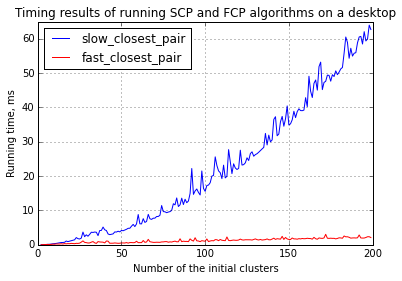

In [54]:
# plot the result as two curves combined in a single plot. (Use a line plot for each curve.) 
# The horizontal axis for your plot should be the the number of initial clusters while the 
# vertical axis should be the running time of the function in seconds.
import matplotlib.pyplot as plt
%matplotlib inline

xvals = time_xcp
plt.plot(xvals, time_scp, '-b', label='slow_closest_pair')
plt.plot(xvals, time_fcp, '-r', label='fast_closest_pair')

plt.xlim([0, 200])
plt.ylim([0, 65])
plt.legend(loc='upper left')
plt.title('Timing results of running SCP and FCP algorithms on a desktop')
plt.xlabel('Number of the initial clusters')
plt.ylabel('Running time, ms')
plt.grid(True)
plt.savefig('p3a1.png')

Loaded 3108 data points
Displaying 15 sequential clusters


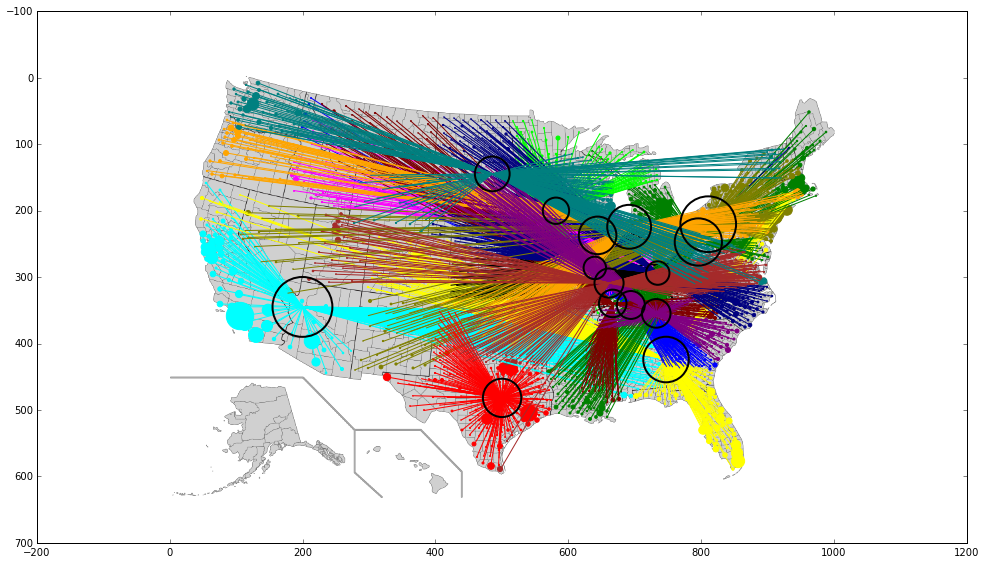

In [56]:
"""
Example code for creating and visualizing
cluster of county-based cancer risk data

Note that you must download the file
http://www.codeskulptor.org/#alg_clusters_matplotlib.py
to use the matplotlib version of this code
"""

# Flavor of Python - desktop or CodeSkulptor
DESKTOP = True #False

import math
import random
import urllib2
import alg_cluster

# conditional imports
if DESKTOP:
    #import alg_project3_solution      # desktop project solution
    import alg_clusters_matplotlib
else:
    import user40_NlNRSpLNSR_12 as student   # CodeSkulptor project solution
    import alg_clusters_simplegui
    import codeskulptor
    codeskulptor.set_timeout(30)


###################################################
# Code to load data tables

# URLs for cancer risk data tables of various sizes
# Numbers indicate number of counties in data table

DIRECTORY = "http://commondatastorage.googleapis.com/codeskulptor-assets/"
DATA_3108_URL = DIRECTORY + "data_clustering/unifiedCancerData_3108.csv"
DATA_896_URL = DIRECTORY + "data_clustering/unifiedCancerData_896.csv"
DATA_290_URL = DIRECTORY + "data_clustering/unifiedCancerData_290.csv"
DATA_111_URL = DIRECTORY + "data_clustering/unifiedCancerData_111.csv"


def load_data_table(data_url):
    """
    Import a table of county-based cancer risk data
    from a csv format file
    """
    data_file = urllib2.urlopen(data_url)
    data = data_file.read()
    data_lines = data.split('\n')
    print "Loaded", len(data_lines), "data points"
    data_tokens = [line.split(',') for line in data_lines]
    return [[tokens[0], float(tokens[1]), float(tokens[2]), int(tokens[3]), float(tokens[4])] 
            for tokens in data_tokens]


############################################################
# Code to create sequential clustering
# Create alphabetical clusters for county data

def sequential_clustering(singleton_list, num_clusters):
    """
    Take a data table and create a list of clusters
    by partitioning the table into clusters based on its ordering
    
    Note that method may return num_clusters or num_clusters + 1 final clusters
    """
    
    cluster_list = []
    cluster_idx = 0
    total_clusters = len(singleton_list)
    cluster_size = float(total_clusters)  / num_clusters
    
    for cluster_idx in range(len(singleton_list)):
        new_cluster = singleton_list[cluster_idx]
        if math.floor(cluster_idx / cluster_size) != \
           math.floor((cluster_idx - 1) / cluster_size):
            cluster_list.append(new_cluster)
        else:
            cluster_list[-1] = cluster_list[-1].merge_clusters(new_cluster)
            
    return cluster_list
                

#####################################################################
# Code to load cancer data, compute a clustering and 
# visualize the results


def run_example():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_3108_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        
    cluster_list = sequential_clustering(singleton_list, 15)	
    print "Displaying", len(cluster_list), "sequential clusters"

    #cluster_list = alg_project3_solution.hierarchical_clustering(singleton_list, 9)
    #print "Displaying", len(cluster_list), "hierarchical clusters"

    #cluster_list = alg_project3_solution.kmeans_clustering(singleton_list, 9, 5)	
    #print "Displaying", len(cluster_list), "k-means clusters"

            
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, False)
        alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
    
run_example()


##2. Question 2 (1 pt). 
###Use alg_project3_viz to create an image of the 15 clusters generated by applying hierarchical clustering to the 3108 county cancer risk data set. You may submit an image with the 3108 counties colored by clusters or an enhanced visualization with the original counties colored by cluster and linked to the center of their corresponding clusters by lines. You can generate such an enhanced plot using our alg_clusters_matplotlib code by modifying the last parameter of plot_clusters to be True. Note that plotting only the resulting cluster centers is not acceptable.

Loaded 3108 data points
Displaying 15 hierarchical clusters


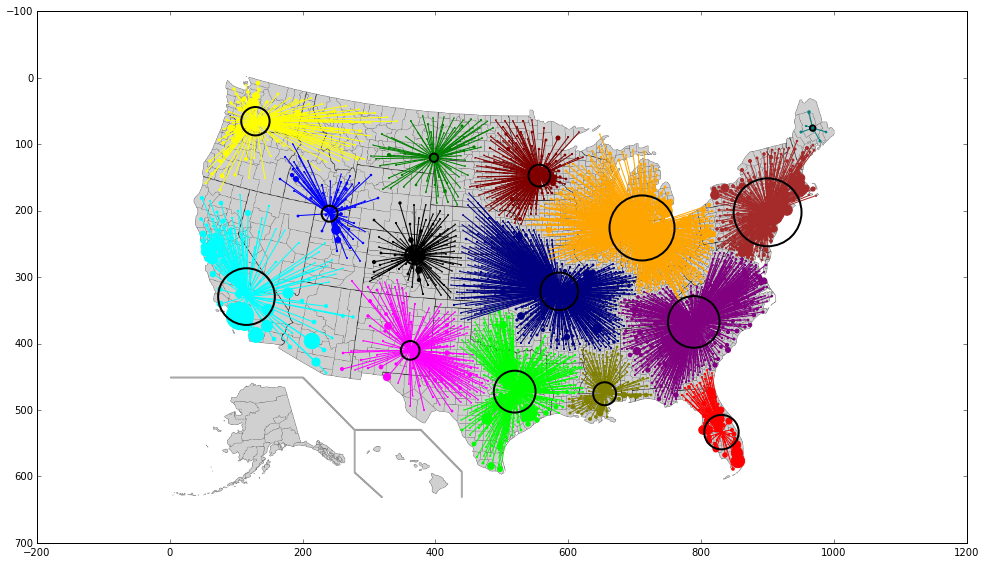

In [57]:
# 15 clusters generated by applying hierarchical clustering to the 3108 county cancer risk data set.

def run_example1():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_3108_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        
    #cluster_list = sequential_clustering(singleton_list, 15)	
    #print "Displaying", len(cluster_list), "sequential clusters"

    cluster_list = hierarchical_clustering(singleton_list, 15)
    print "Displaying", len(cluster_list), "hierarchical clusters"

    #cluster_list = alg_project3_solution.kmeans_clustering(singleton_list, 9, 5)	
    #print "Displaying", len(cluster_list), "k-means clusters"

            
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, False)
        alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
    
run_example1()
plt.savefig('p3a2.png')

##3. Question 3 (1 pt)
###Use alg_project3_viz to create an image of the 15 clusters generated by applying 5 iterations of k-means clustering to the 3108 county cancer risk data set. You may submit an image with the 3108 counties colored by clusters or an enhanced visualization with the original counties colored by cluster and linked to the center of their corresponding clusters by lines. As in Project 3, the initial clusters should correspond to the 15 counties with the largest populations.

Loaded 3108 data points
Displaying 15 k-means clusters


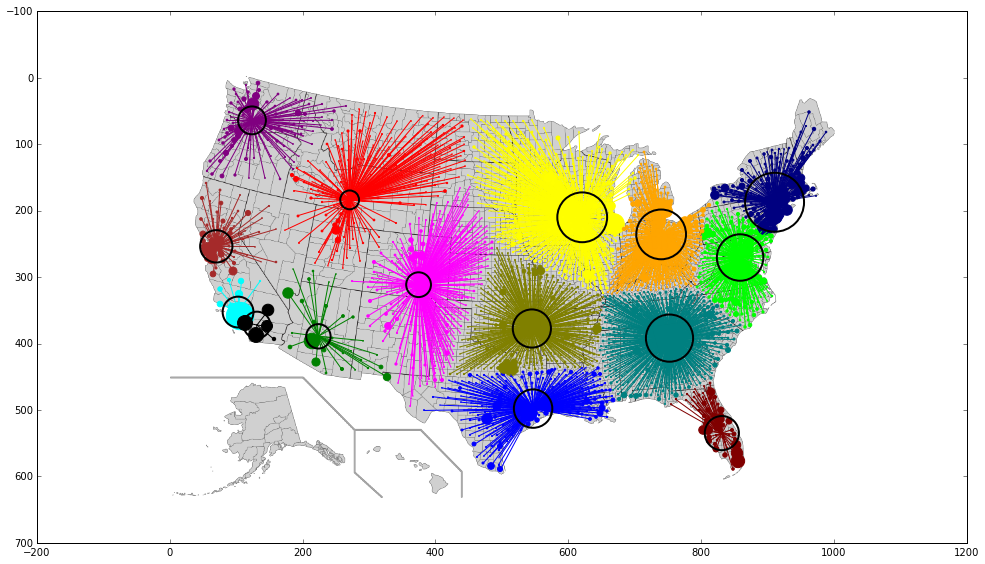

In [59]:
# create an image of the 15 clusters generated by applying 5 iterations of k-means clustering 
# to the 3108 county cancer risk data set.

def run_example2():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_3108_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        
    #cluster_list = sequential_clustering(singleton_list, 15)	
    #print "Displaying", len(cluster_list), "sequential clusters"

    #cluster_list = hierarchical_clustering(singleton_list, 15)
    #print "Displaying", len(cluster_list), "hierarchical clusters"

    cluster_list = kmeans_clustering(singleton_list, 15, 5)
    print "Displaying", len(cluster_list), "k-means clusters"

            
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, False)
        alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
    
run_example2()
plt.savefig('p3a3.png')

##Question 5 (1 pt)
###Use alg_project3_viz to create an image of the 9 clusters generated by applying hierarchical clustering to the 111 county cancer risk data set. You may submit an image with the 111 counties colored by clusters or an enhanced visualization with the original counties colored by cluster and linked to the center of their corresponding clusters by lines.

Loaded 111 data points
Displaying 9 hierarchical clusters


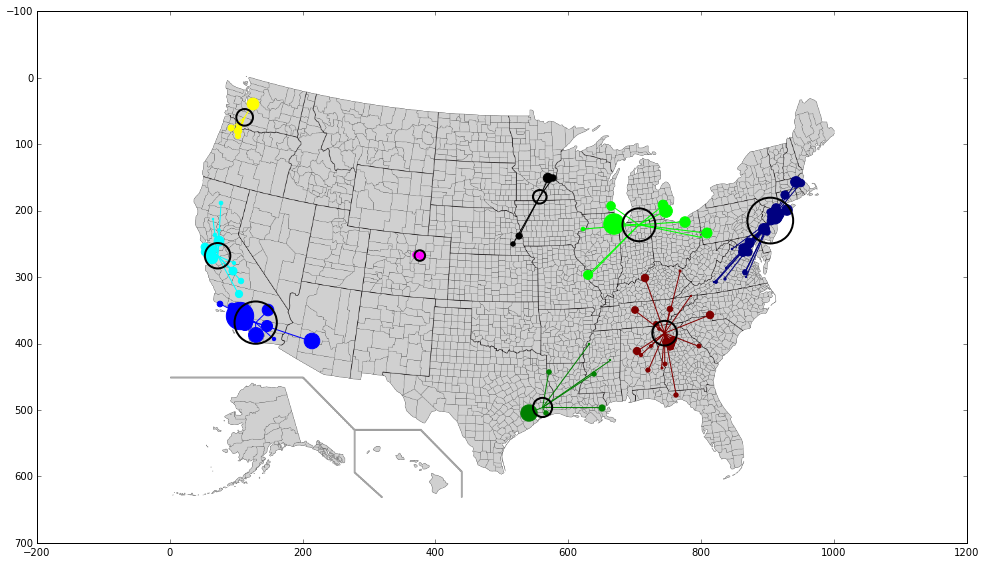

In [62]:
#create an image of the 9 clusters generated by applying hierarchical clustering 
#to the 111 county cancer risk data set.
def run_example3():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_111_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        
    #cluster_list = sequential_clustering(singleton_list, 15)	
    #print "Displaying", len(cluster_list), "sequential clusters"

    cluster_list = hierarchical_clustering(singleton_list, 9)
    print "Displaying", len(cluster_list), "hierarchical clusters"

    #cluster_list = alg_project3_solution.kmeans_clustering(singleton_list, 9, 5)	
    #print "Displaying", len(cluster_list), "k-means clusters"

            
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, False)
        alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
    
run_example3()
plt.savefig('p3a4.png')

##Question 6 (1 pt)
###Use alg_project3_viz to create an image of the 9 clusters generated by applying 5 iterations of k-means clustering to the 111 county cancer risk data set. You may submit an image with the 111 counties colored by clusters or an enhanced visualization with the original counties colored by cluster and linked to the center of their corresponding clusters by lines. As in Project 3, the initial clusters should correspond to the 9 counties with the largest populations.

Loaded 111 data points
Displaying 9 k-means clusters


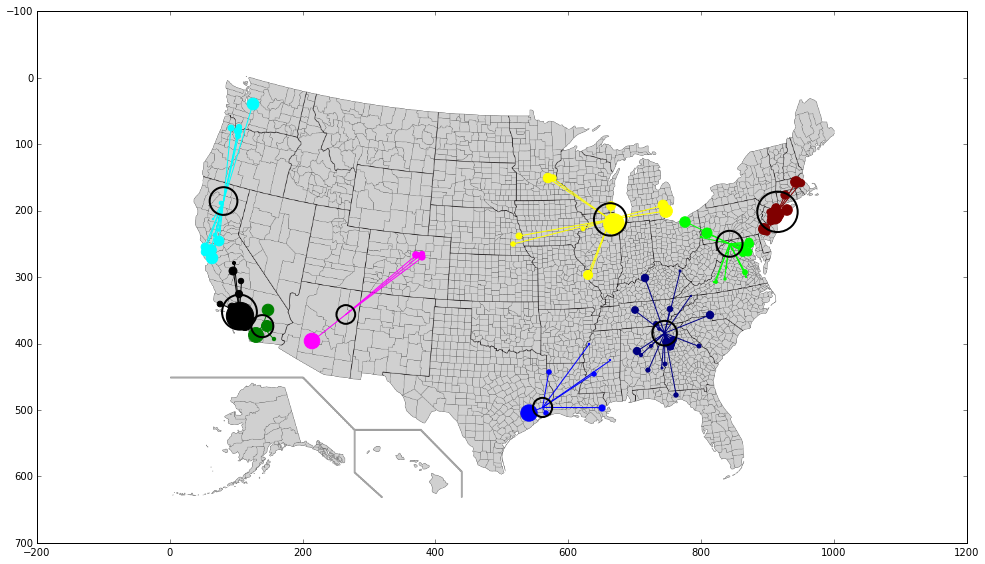

In [63]:
# create an image of the 9 clusters generated by applying 5 iterations 
# of k-means clustering to the 111 county cancer risk data set. 
def run_example3():
    """
    Load a data table, compute a list of clusters and 
    plot a list of clusters

    Set DESKTOP = True/False to use either matplotlib or simplegui
    """
    data_table = load_data_table(DATA_111_URL)
    
    singleton_list = []
    for line in data_table:
        singleton_list.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        
    #cluster_list = sequential_clustering(singleton_list, 15)	
    #print "Displaying", len(cluster_list), "sequential clusters"

    #cluster_list = hierarchical_clustering(singleton_list, 9)
    #print "Displaying", len(cluster_list), "hierarchical clusters"

    cluster_list = kmeans_clustering(singleton_list, 9, 5)
    print "Displaying", len(cluster_list), "k-means clusters"
    
    
    
            
    # draw the clusters using matplotlib or simplegui
    if DESKTOP:
        #alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, False)
        alg_clusters_matplotlib.plot_clusters(data_table, cluster_list, True)  #add cluster centers
    else:
        alg_clusters_simplegui.PlotClusters(data_table, cluster_list)   # use toggle in GUI to add cluster centers
    
run_example3()
plt.savefig('p3a5.png')


##Question 7 (1 pt)
###Write a function compute_distortion(cluster_list) that takes a list of clusters and uses cluster_error to compute its distortion. Now, use compute_distortion to compute the distortions of the two clusterings in questions 5 and 6. Enter the values for the distortions (with at least four significant digits) for these two clusterings in the box below. Clearly indicate the clusterings to which each value corresponds.

In [80]:
# create clusters for DATA111
data_table111 = load_data_table(DATA_111_URL)
data_table290 = load_data_table(DATA_290_URL)

singleton_list_hc = []
singleton_list_kmc = []
for line in data_table260:
    singleton_list_hc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
    singleton_list_kmc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
    
cluster_list_hc_16 = hierarchical_clustering(singleton_list_hc, 16)    
cluster_list_kmc_16_5 = kmeans_clustering(singleton_list_kmc, 16, 5)


singleton_list_hc = []
singleton_list_kmc = []
for line in data_table111:
    singleton_list_hc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
    singleton_list_kmc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
    
cluster_list_hc_9 = hierarchical_clustering(singleton_list_hc, 9)    
cluster_list_kmc_9_5 = kmeans_clustering(singleton_list_kmc, 9, 5)

Loaded 111 data points
Loaded 290 data points


In [78]:
def compute_distortion(cluster_list, data_table):
    """
    This function takes a list of clusters and uses cluster_error to compute its distortion. 
    """
    distortion = 0.0
    for idx in range(len(cluster_list)):
        distortion += cluster_list[idx].cluster_error(data_table)
    return distortion

In [81]:
#computing values
#print type(cluster_list_hc_16[0])


hierarchical_distortion_16 = compute_distortion(cluster_list_hc_16, data_table290)
k_mean_distortion_16_5 = compute_distortion(cluster_list_kmc_16_5, data_table290)

hierarchical_distortion_9 = compute_distortion(cluster_list_hc_9, data_table111)
k_mean_distortion_9_5 = compute_distortion(cluster_list_kmc_9_5, data_table111)

# 16 output clusters produced by hierarchical clustering and k-means clustering (with 5 iterations) 
# on the 290 county data set are approximately 2.575×1011 and 2.323×1011
print 'hierarchical_distortion_16', hierarchical_distortion_16
print 'k_mean_distortion_16_5', k_mean_distortion_16_5
print 'hierarchical_distortion_9', hierarchical_distortion_9
print 'k_mean_distortion_9_5', k_mean_distortion_9_5

hierarchical_distortion_16 2.5752309447e+11
k_mean_distortion_16_5 2.32286884261e+11
hierarchical_distortion_9 1.75163886916e+11
k_mean_distortion_9_5 2.71254226924e+11


##Question 10 (4 pts)
###Compute the distortion of the list of clusters produced by hierarchical clustering and k-means clustering (using 5 iterations) on the 111, 290, and 896 county data sets, respectively, where the number of output clusters ranges from 6 to 20 (inclusive). Important note: To compute the distortion for all 15 output clusterings produced by hierarchical_clustering, you should remember that you can use the hierarchical cluster of size 20 to compute the hierarchical clustering of size 19 and so on. Otherwise, you will introduce an unnecessary factor of 15 into the computation of the 15 hierarchical clusterings.
###Once you have computed these distortions for both clustering methods, create three separate plots (one for each data set) that compare the distortion of the clusterings produced by both methods. Each plot should include two curves drawn as line plots. The horizontal axis for each plot should indicate the number of output clusters while the vertical axis should indicate the distortion associated with each output clustering. For each plot, include a title that indicates the data set used in creating the plots and a legend that distinguishes the two curves.

In [90]:
cluster_range = range(6, 21, 1)
#print cluster_range
data_table896 = load_data_table(DATA_896_URL)

hierarchical_distortion_111 = []
k_mean_distortion_111 = []
for cluster_num in cluster_range:
    singleton_list_hc = []
    singleton_list_kmc = []
    for line in data_table111:
        singleton_list_hc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        singleton_list_kmc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))

    cluster_list_hc = hierarchical_clustering(singleton_list_hc, cluster_num)    
    cluster_list_kmc = kmeans_clustering(singleton_list_kmc, cluster_num, 5)

    hierarchical_distortion = compute_distortion(cluster_list_hc, data_table111)
    hierarchical_distortion_111.append(hierarchical_distortion)
    k_mean_distortion = compute_distortion(cluster_list_kmc, data_table111)
    k_mean_distortion_111.append(k_mean_distortion)
    print "Done with cluster number = ", cluster_num

print hierarchical_distortion_111
print k_mean_distortion_111

Loaded 896 data points
Done with cluster number =  6
Done with cluster number =  7
Done with cluster number =  8
Done with cluster number =  9
Done with cluster number =  10
Done with cluster number =  11
Done with cluster number =  12
Done with cluster number =  13
Done with cluster number =  14
Done with cluster number =  15
Done with cluster number =  16
Done with cluster number =  17
Done with cluster number =  18
Done with cluster number =  19
Done with cluster number =  20
[473061548301.70715, 304487213235.6512, 256295541683.3451, 175163886915.8305, 136007319294.45241, 128691501288.44057, 123364931819.36792, 95061330400.91187, 92851824733.8917, 83751677988.91675, 76305792806.40341, 75195590422.55962, 47956771398.36998, 43572685067.322044, 43346616567.370995]
[855406302600.9299, 480503404944.00757, 430845493901.4979, 271254226924.20047, 175790688405.04092, 174267507472.60236, 173535638065.6752, 173058588040.28055, 165471040577.26993, 164745271371.3518, 163567291743.99063, 16201802

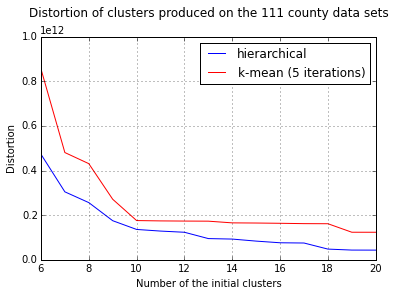

In [105]:
# plotting distortions for 111 data_table
xvals = cluster_range
plt.plot(xvals, hierarchical_distortion_111, '-b', label='hierarchical')
plt.plot(xvals, k_mean_distortion_111, '-r', label='k-mean (5 iterations)')

plt.xlim([6, 20])
plt.ylim([0, 1000000000000])
plt.legend(loc='upper right')
plt.title('Distortion of clusters produced on the 111 county data sets \n')
plt.xlabel('Number of the initial clusters')
plt.ylabel('Distortion')
plt.grid(True)
plt.savefig('p3a6_111.png')

In [101]:
# for 290
hierarchical_distortion_290 = []
k_mean_distortion_290 = []
for cluster_num in cluster_range:
    singleton_list_hc = []
    singleton_list_kmc = []
    for line in data_table290:
        singleton_list_hc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        singleton_list_kmc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))

    cluster_list_hc = hierarchical_clustering(singleton_list_hc, cluster_num)    
    cluster_list_kmc = kmeans_clustering(singleton_list_kmc, cluster_num, 5)

    hierarchical_distortion = compute_distortion(cluster_list_hc, data_table290)
    hierarchical_distortion_290.append(hierarchical_distortion)
    k_mean_distortion = compute_distortion(cluster_list_kmc, data_table290)
    k_mean_distortion_290.append(k_mean_distortion)
    print "Done with cluster number = ", cluster_num

print hierarchical_distortion_290
print k_mean_distortion_290

Done with cluster number =  6
Done with cluster number =  7
Done with cluster number =  8
Done with cluster number =  9
Done with cluster number =  10
Done with cluster number =  11
Done with cluster number =  12
Done with cluster number =  13
Done with cluster number =  14
Done with cluster number =  15
Done with cluster number =  16
Done with cluster number =  17
Done with cluster number =  18
Done with cluster number =  19
Done with cluster number =  20
[1721363375274.0854, 873386979469.7283, 607704110695.7352, 607404453849.4805, 479106607308.0914, 452595640777.71625, 409759400590.0937, 300957083742.44525, 273999812286.67493, 265642320327.18253, 257523094470.34372, 210882439099.43875, 209424475932.79623, 165854841465.23853, 158866394846.55304]
[1432446364647.484, 1256566786124.0432, 726141205120.559, 656031563613.5233, 619318206656.0833, 557173759501.5332, 449630999209.31024, 397796574329.07294, 397061951861.4956, 238910074068.03934, 232286884261.00916, 220231070772.07336, 218182336

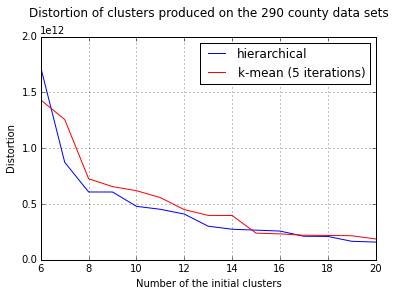

In [107]:
# plotting distortions for 290 data_table
xvals = cluster_range
plt.plot(xvals, hierarchical_distortion_290, '-b', label='hierarchical')
plt.plot(xvals, k_mean_distortion_290, '-r', label='k-mean (5 iterations)')

plt.xlim([6, 20])
plt.ylim([0, 2000000000000])
plt.legend(loc='upper right')
plt.title('Distortion of clusters produced on the 290 county data sets \n')
plt.xlabel('Number of the initial clusters')
plt.ylabel('Distortion')
plt.grid(True)
plt.savefig('p3a7_290.png')

In [109]:
# for 896
hierarchical_distortion_896 = []
k_mean_distortion_896 = []
for cluster_num in cluster_range:
    singleton_list_hc = []
    singleton_list_kmc = []
    for line in data_table896:
        singleton_list_hc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))
        singleton_list_kmc.append(alg_cluster.Cluster(set([line[0]]), line[1], line[2], line[3], line[4]))

    cluster_list_hc = hierarchical_clustering(singleton_list_hc, cluster_num)    
    cluster_list_kmc = kmeans_clustering(singleton_list_kmc, cluster_num, 5)

    hierarchical_distortion = compute_distortion(cluster_list_hc, data_table896)
    hierarchical_distortion_896.append(hierarchical_distortion)
    k_mean_distortion = compute_distortion(cluster_list_kmc, data_table896)
    k_mean_distortion_896.append(k_mean_distortion)
    print "Done with cluster number = ", cluster_num

print hierarchical_distortion_896
print k_mean_distortion_896

Done with cluster number =  6
Done with cluster number =  7
Done with cluster number =  8
Done with cluster number =  9
Done with cluster number =  10
Done with cluster number =  11
Done with cluster number =  12
Done with cluster number =  13
Done with cluster number =  14
Done with cluster number =  15
Done with cluster number =  16
Done with cluster number =  17
Done with cluster number =  18
Done with cluster number =  19
Done with cluster number =  20
[2211819145957.39, 1263342391158.555, 1228012004919.8132, 972923457621.6614, 947764944638.2125, 887973140164.1119, 775480684213.734, 635476455541.3552, 581040540888.1357, 509864466993.6245, 504815920302.4635, 468733959164.03394, 466383317148.9524, 463371219437.65283, 377806730495.8185]
[2376173737632.8, 1632162002379.899, 1149516152182.7866, 1005638949041.6797, 941617184525.7502, 873017865209.888, 717297472806.9475, 707481162063.751, 693980006271.2808, 477113007869.9135, 475260676178.591, 441641633333.34503, 418814444487.6942, 392190

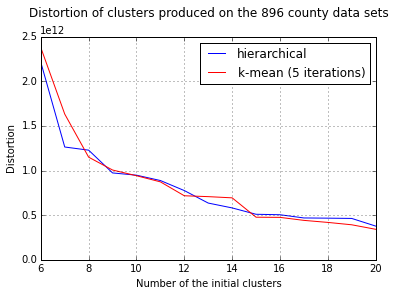

In [112]:
# plotting distortions for 896 data_table
xvals = cluster_range
plt.plot(xvals, hierarchical_distortion_896, '-b', label='hierarchical')
plt.plot(xvals, k_mean_distortion_896, '-r', label='k-mean (5 iterations)')

plt.xlim([6, 20])
plt.ylim([0, 2500000000000])
plt.legend(loc='upper right')
plt.title('Distortion of clusters produced on the 896 county data sets \n')
plt.xlabel('Number of the initial clusters')
plt.ylabel('Distortion')
plt.grid(True)
plt.savefig('p3a8_896.png')